In [1]:
#Import statements
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import matplotlib.animation
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import math
from skimage import filters

In [2]:
#Functions
'''Adapted from stack overflow response from Jeru Luke, 
https://stackoverflow.com/questions/51285593/converting-an-image-to-grayscale-using-numpy

Takes in color image and converts to gray scale'''
def grayConversion(image):
    grayValue = 0.07 * image[:,:,2] + 0.72 * image[:,:,1] + 0.21 * image[:,:,0]
    gray_img = grayValue.astype(np.uint8)
    return gray_img
'''
    The bucketTracker function takes in a frame from a video of a paint bucket attached to a spring
    oscillating in time and tracks the position of the paint bucket across each frame of the video.
    This is accomplished by applying a foreground filter skimage.filters.threshold_otsu to the edges
    of the image (to eliminate instances of erroneously tracking elements of the video background),
    as well as a high pass edge detection filter. Both of the filters are controllable with funciton
    parameters. The amount of the image subjected to the foreground filter is controllable in both the
    x and y direction, and the extent to which low frequencies are attenuated by the high pass filter is
    also controllable. After filtering the function then proceeds to increase the contrast of the image by
    blacking out (setting pixel values to zero) all pixels below a certain threshold while amplifying pixels
    above the threshold to the maximum grayscale pixel value of 255. This is done because the color of the paint
    can is white, and amplifying the contrast of the pixel values of the can is desirable for good tracking
    performance. This filtered, enhanced contrast version of the original video frame is then searched over using
    a window technique to find the square window of pixel values with the highest average pixel value. This will
    correspond to the location of the paint bucket for the given frame.

    
    INPUTS:
    data: numpy.ndarray of signal to analyze.
    pix_thresh: scalar value indicating the relative (i.e. pix_thresh = x/255) pixel value below which
                pixels will be blacked out (i.e. set to 0) and above which will be amplified (i.e. set to 255)
    prefilter: Boolean value indicating whether to use the contrast enhancing feature which amplifies
                pixel values above pix_thresh, and zeros out all values below the threshold.
    window_size: scalar value indicating the size of the search window to use when looking for the 
                maximum average pixel value corresponding to the position of the bucket
    search_restrict: scalar value indicating the size of the square window around which the algorithm will
                    begin searching relative to the last known position.
    error_thresh: scalar value indicating the tolerance for the tracking position to jump between frames
    keep_fraction: scalar value indicating the relative number of frequencies to keep during high pass filtering
    mask_length: scalar value indicating the thickness of the edge in the y-direction of the
                    foreground filter.
    mask_width: scalar value indicating the thicknes of the edge in the x-direction of the
                foreground filter.
    highPassFilter: boolean value indicating whether or not to apply the high pass filter
    
    OUTPUTS:
    positions: numpy.ndarray of the determined position (x,y pixel values) of the paint bucket in each frame
    new_movie: nump.ndarray of the video frames after filtering and contrast enhancement to demonstrate
                what the function does to the video file. This aids in tuning the parameters of the filters
                and thresholds so as to best track the bucket.
'''
def bucketTracker(data, pix_thresh, prefilter=True, window_size=10, search_restrict=40, 
                  error_thresh=0.70, keep_fraction=0.1, mask_length = 0.1, mask_width = 0.1,
                 highPassFilter=True):
    #find bucket pixel position using the flashlight due to identifiably high whiteness.
    [w, h, rgb, tp] = data.shape
    new_movie = np.empty([w, h, tp])
    positions = np.empty([tp, 2])#array to hold positions of paint can in each movie frame
    start_j = 0#y coordinate for starting search for paint can
    start_k = 0#x coordinate for starting search for paint can
    stop_j = h#y coordinate to stop search for paint can
    stop_k = w#x coordinate to stop search for paint can

    #iterate over each frame of the movie
    for i in range(0, tp): #iterate over each frame
        print("Progress {:2.1%}".format(i / tp), end="\r")#print progress of paint can position acquisition
        gf = grayConversion(data[:,:,:,i])#convert RGB frame to gray scale pixel values
        val = filters.threshold_otsu(gf)
        foreground_mask = gf < val
        ledge = mask_length#specifies how much of the edge of the foreground filter to include in the x direction
        wedge = mask_width#specifies how much of the edge of the foreground filter to include in the y direction
        rfg, cfg = foreground_mask.shape#Set r and c to be the number of rows and columns of the array.
        foreground_mask[int(rfg*(wedge)):int(rfg*(1-wedge)),int(cfg*ledge):int(cfg*(1-ledge))] = 1
        
        if highPassFilter:
            imfft = np.fft.fft2(gf)#discrete fourier transform of movie frame
            #high pass filter for edge detection
            r, c = imfft.shape#Set r and c to be the number of rows and columns of the array.
            mask = np.zeros((r, c))#initialize mask of zeros to act as foundation for high pass filter
            # Set to 1 all rows with indices between r*keep_fraction and
            # r*(1-keep_fraction):
            mask[int(r*keep_fraction):int(r*(1-keep_fraction))] = 1

            # Similarly with the columns:
            mask[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 1
            im_lp = imfft*mask#Apply high pass filter mask
            imifft = np.fft.ifft2(im_lp)#inverse fourier transform
        else:
            imifft = 1.0
        
        gf = gf*((abs(imifft)/np.amax(abs(imifft))))*foreground_mask.astype(int)
        #iterate over each column of the frame and highlight the whitest pixels while blackening
        #every pixel below the set threshold. This serves to emphasize what pixels might be from
        #the flashlight on top of the paint can in the movie
        if prefilter:
            for l in range(0, h):
                vec = gf[:, l]#grab column vector of pixel data
                for m in range(0, w):#iterate over the column of pixel data
                    if vec[m] > pix_thresh*255:#if a pixel value is above the threshold for white
                        vec[m] = 255#maximize white value
                    else:
                        vec[m] = 0#otherwise zero out (blacken) the pixel
                gf[:, l] = vec#overwrite pixel data of the frame with new filtered pixel values
                
        #window_size = 10#set a window size to use for iterating over the frame to look for the flashlight
        window_area = window_size**2#calculate the area of the window for calculating average window pixel value later
        av_max = 0#initialize a maximum average window pixel value for initial maximum average value comparison
        pos = np.array([0, 0])#initialize an array to contain the determined position of the flashlight in the frame

        #iterate over the specified search window to find the flashlight indicated by maximum average window pixel value
        #the first search will iterate across the entire frame. subsequent frame searches will restric the search
        #window to a smaller area surrounding the last known flashlight position
        for j in np.arange(start_j, stop_j, window_size):
            for k in np.arange(start_k, stop_k, window_size):
                if ((j + window_size) > h) and ((k + window_size) > w):#if the window is out of frame in both x and z direction
                    window = gf[j:h, k:w]#truncate window so the edge of the window is the edge of the frame
                elif (j + window_size) > h:#if the window is out of frame in the y direction
                    window = gf[j:h, k:k + window_size]#truncate window so the edge of the window is the edge of the frame
                elif (k + window_size) > w:#if the window is out of the frame in the x direction
                    window = gf[j:j + window_size, k:w]#truncate window so the edge of the window is the edge of the frame
                else:#otherwise the window size is unrestricted
                    window = gf[j:j + window_size, k:k + window_size]

                av = np.sum(np.sum(window)) / window_area#calculate the average pixel value of the window
                av_max = max(av, av_max)#compare the average window value to the previous maximum value
                if av_max == av:#if the max is the newest calculated value update the position of the paint can to be the guess
                    pos = np.array([k, j])

        #update the start of the search window to be just before the last known position
        start_j = pos[1] - search_restrict
        start_k = pos[0] - search_restrict
        #update the end of the search window to be just after the last known position
        stop_j = pos[1] + search_restrict
        stop_k = pos[0] + search_restrict
        
        #add bounds so that the subframe searched for the paint can cannot ever be out of bounds of the movie frame
        if start_j < 0:
            start_j = 0
        if start_k < 0:
            start_k = 0
        if stop_j > h:
            stop_j = h
        if stop_k > w:
            stop_k = w
        
        #safety check to exclude points that are obviously erronious.
        if (i > 1):#if analyzing any frame but the first frame
            #check if the y position of the flashlight is +/-70 percent the value of the previous position
            false_y = (pos[1] < ((1 - error_thresh)*positions[i - 1, 1])) or (pos[1] > ((1 + error_thresh)*positions[i - 1, 1]))
            #check if the x position of the flashlight is +/-70 percent the value of the previous position
            false_x = (pos[0] < ((1 - error_thresh)*positions[i - 1, 0])) or (pos[0] > ((1 + error_thresh)*positions[i - 1, 0]))
            if (false_y or false_x):# if the new calcluated position is outside this window +/- 70% for either coordinate
                pos = np.array([positions[i - 1, 0], positions[i - 1, 1]])#rewrite the new position to be the last known position
        
        positions[i,:] = pos#update array of paint can positions with the new position for the current frame
        new_movie[:,:,i] = gf
    return positions, new_movie

In [ ]:
#Data matrix contains camera pixel data RGB for spring mass movies
c_ = loadmat('cam1_1.mat')#load MATLAB .mat file into python as a dictionary
c1 = c_['vidFrames1_1']#raw camera data matrix

#Data matrix contains camera pixel data RGB for spring mass movies
c_ = loadmat('cam2_1.mat')#load MATLAB .mat file into python as a dictionary
c2 = c_['vidFrames2_1']#raw camera data matrix

#Data matrix contains camera pixel data RGB for spring mass movies
c_ = loadmat('cam3_1.mat')#load MATLAB .mat file into python as a dictionary
c3 = c_['vidFrames3_1']#raw camera data matrix

[w, h, rgb, tp] = c1.shape

In [ ]:
#track the paint bucket for each camera
pc1, nm1 = bucketTracker(c1, 0.6, True, 10, 100, 0.70, 0.005, 0.3, 0.1, True)
pc2, nm2 = bucketTracker(c2, 0.7, True, 10, 100, 0.70, 0.0025, 0.3, 0.15, True)
pc3, nm3 = bucketTracker(c3, 0.6, True, 10, 100, 0.70, 0.005, 0.25, 0.1, True)

In [ ]:
#show movie of first test with actual video
%matplotlib notebook
f = plt.figure()
ax = f.gca()
ax.set_xlim(( 0, h))
ax.set_ylim((w, 0))

image = plt.imshow(c3[:,:,:,0], animated=True)
graph, = plt.plot([], [], 'bo')

x = pc3[:, 0]
y = pc3[:, 1]

def animate(i):
    image.set_data(c3[:,:,:,i])
    graph.set_data(x[i], y[i])
    ax.set_title(i)
    return image, graph,

ani = matplotlib.animation.FuncAnimation(f, animate, frames=tp, interval=200)
plt.show()

In [ ]:
#show movie of first test, with filtered movie frames
%matplotlib notebook#necessary to show animations inline in jupyter notebook
f = plt.figure()#define figure
ax = f.gca()#define axes
ax.set_xlim(( 0, h))
ax.set_ylim((w, 0))

image = plt.imshow(nm3[:,:,0], animated=True)#define first animation frame
graph, = plt.plot([], [], 'bo')#define first animation graph of tracked position

x = pc3[:, 0]#x positional data
y = pc3[:, 1]#y positional data

def animate(i):
    image.set_data(nm3[:,:,i])#update animation video frame
    graph.set_data(x[i], y[i])#update position of tracked can
    ax.set_title(i)
    return image, graph,

ani = matplotlib.animation.FuncAnimation(f, animate, frames=tp, interval=200)#animation
plt.show()

In [ ]:
#plot positional data for each frame of the video for each camera in the x direction
%matplotlib inline
f, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(10, 15))
ax1.plot(np.arange(0,226), pc1[:, 0])
ax1.set_title('Camera 1 X axis Oscillations')
ax1.set_ylabel('Amplitude [pixels]')
ax1.set_xlabel('Movie Frame')
ax2.plot(np.arange(0,284), pc2[:, 0])
ax2.set_title('Camera 2 X axis Oscillations')
ax2.set_ylabel('Amplitude [pixels]')
ax2.set_xlabel('Movie Frame')
ax3.plot(np.arange(0,232), pc3[:, 0])
ax3.set_title('Camera 3 X axis Oscillations')
ax3.set_ylabel('Amplitude [pixels]')
ax3.set_xlabel('Movie Frame')

In [ ]:
#plot positional data for each frame of the video for each camera in the y direction
%matplotlib inline
f, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(10, 15))
ax1.plot(np.arange(0,226), pc1[:, 1])
ax1.set_title('Camera 1 Y axis Oscillations')
ax1.set_ylabel('Amplitude [pixels]')
ax1.set_xlabel('Movie Frame')
ax2.plot(np.arange(0,284), pc2[:, 1])
ax2.set_title('Camera 2 Y axis Oscillations')
ax2.set_ylabel('Amplitude [pixels]')
ax2.set_xlabel('Movie Frame')
ax3.plot(np.arange(0,232), pc3[:, 1])
ax3.set_title('Camera 3 Y axis Oscillations')
ax3.set_ylabel('Amplitude [pixels]')
ax3.set_xlabel('Movie Frame')

In [ ]:
#prepare data for principal component analysis through stadard scaling of each camera's positional data
camdf = pd.DataFrame(data=pc1)
camdfs = StandardScaler().fit_transform(camdf)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(camdfs)
pDf_1 = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

camdf = pd.DataFrame(data=pc2)
camdfs = StandardScaler().fit_transform(camdf)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(camdfs)
pDf_2 = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

camdf = pd.DataFrame(data=pc3)
camdfs = StandardScaler().fit_transform(camdf)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(camdfs)
pDf_3 = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

In [ ]:
%matplotlib inline
d = {'cam1x': pDf_1.loc[:, 'PC1'], 'cam1y': pDf_1.loc[:, 'PC2'], 'cam2x': pDf_2.loc[:, 'PC1'], 
     'cam2y': pDf_2.loc[:, 'PC2'], 'cam3x': pDf_3.loc[:, 'PC1'], 'cam3y': pDf_3.loc[:, 'PC2']}

df = pd.DataFrame(data=d)
df = df.iloc[0:226]
dfs = StandardScaler().fit_transform(df)


pca = PCA(n_components=6)
principalComponents = pca.fit_transform(dfs)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6'])

#Principle component oscillations
f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot(np.arange(0,226), principalDf.loc[:,'PC1'], label='PC1')
ax1.plot(np.arange(0,226), principalDf.loc[:,'PC2'], label='PC2', alpha=0.35)
ax1.plot(np.arange(0,226), principalDf.loc[:,'PC3'], label='PC3', alpha=0.35)
ax1.set_title('Test 1 Total Camera Positional Data Principal Component Projections')
ax1.set_ylabel('Standardized Amplitude [pixels]')
ax1.set_xlabel('Movie Frame')
ax1.legend()

In [ ]:
#Principle component oscillations
%matplotlib inline
f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot(np.arange(1,len(pca.explained_variance_) + 1,1).astype(int), 100*pca.explained_variance_/sum(pca.explained_variance_), 'bo', fillStyle='none')
ax1.set_xticks(np.arange(0,len(pca.explained_variance_) + 1,1)) 
ax1.set_title('Test 1 Explained Variance by Principal Component')
ax1.set_ylabel('Percent Explained Variance [%]')
ax1.set_xlabel('Principal Component')
ax1.set_xlim([0.5, 6.5])

In [3]:
#Test 2
#Data matrix contains camera pixel data RGB for spring mass movies
c_ = loadmat('cam1_2.mat')#load MATLAB .mat file into python as a dictionary
c1 = c_['vidFrames1_2']#raw camera data matrix

#Data matrix contains camera pixel data RGB for spring mass movies
c_ = loadmat('cam2_2.mat')#load MATLAB .mat file into python as a dictionary
c2 = c_['vidFrames2_2']#raw camera data matrix

#Data matrix contains camera pixel data RGB for spring mass movies
c_ = loadmat('cam3_2.mat')#load MATLAB .mat file into python as a dictionary
c3 = c_['vidFrames3_2']#raw camera data matrix

[w, h, rgb, tp] = c1.shape

In [4]:
pc1, nm1 = bucketTracker(c1, 0.6, True, 10, 100, 0.70, 0.0025, 0.3, 0.15, True)
pc2, nm2 = bucketTracker(c2, 0.85, True, 10, 100, 0.70, 0.0015, 0.3, 0.15, True)
pc3, nm3 = bucketTracker(c3, 0.6, True, 10, 100, 0.70, 0.0025, 0.25, 0.2, True)

In [ ]:
#show movie of second test, with filtered movie frames
%matplotlib notebook
f = plt.figure()
ax = f.gca()
ax.set_xlim(( 0, h))
ax.set_ylim((w, 0))

image = plt.imshow(nm3[:,:,0], animated=True)
graph, = plt.plot([], [], 'bo')

x = pc3[:, 0]
y = pc3[:, 1]

def animate(i):
    image.set_data(nm3[:,:,i])
    graph.set_data(x[i], y[i])
    ax.set_title(i)
    return image, graph,

ani = matplotlib.animation.FuncAnimation(f, animate, frames=tp, interval=200)
plt.show()

In [ ]:
#show movie of second test with actual video
%matplotlib notebook
f = plt.figure()
ax = f.gca()
ax.set_xlim(( 0, h))
ax.set_ylim((w, 0))

image = plt.imshow(c3[:,:,:,0], animated=True)
graph, = plt.plot([], [], 'bo')

x = pc3[:, 0]
y = pc3[:, 1]

def animate(i):
    image.set_data(c3[:,:,:,i])
    graph.set_data(x[i], y[i])
    ax.set_title(i)
    return image, graph,

ani = matplotlib.animation.FuncAnimation(f, animate, frames=tp, interval=200)
plt.show()

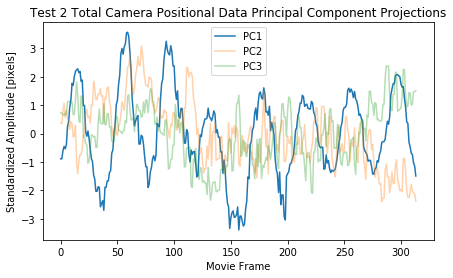

In [7]:
#Run principal component analysis after stadard scaling on each camera's positional data to determine axes of
#maximal variance
%matplotlib inline
camdf = pd.DataFrame(data=pc1)
camdfs = StandardScaler().fit_transform(camdf)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(camdfs)
pDf_1 = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

camdf = pd.DataFrame(data=pc2)
camdfs = StandardScaler().fit_transform(camdf)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(camdfs)
pDf_2 = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

camdf = pd.DataFrame(data=pc3)
camdfs = StandardScaler().fit_transform(camdf)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(camdfs)
pDf_3 = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

#build dictionary of principal component data for each camera for analysis of all cameras together
d = {'cam1x': pDf_1.loc[:, 'PC1'], 'cam1y': pDf_1.loc[:, 'PC2'], 'cam2x': pDf_2.loc[:, 'PC1'], 
     'cam2y': pDf_2.loc[:, 'PC2'], 'cam3x': pDf_3.loc[:, 'PC1'], 'cam3y': pDf_3.loc[:, 'PC2']}

df = pd.DataFrame(data=d)
df = df.iloc[0:314]#truncate data depending on the camera with the least number of recorded frames
dfs = StandardScaler().fit_transform(df)

#perform PCA on all the camera data together
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(dfs)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6'])

#Principle component oscillations
f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot(np.arange(0,314), principalDf.loc[:,'PC1'], label='PC1')
ax1.plot(np.arange(0,314), principalDf.loc[:,'PC2'], label='PC2', alpha=0.35)
ax1.plot(np.arange(0,314), principalDf.loc[:,'PC3'], label='PC3', alpha=0.35)
ax1.set_title('Test 2 Total Camera Positional Data Principal Component Projections')
ax1.set_ylabel('Standardized Amplitude [pixels]')
ax1.set_xlabel('Movie Frame')
ax1.legend()

In [ ]:
#Principle component oscillations
%matplotlib inline
f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot(np.arange(1,len(pca.explained_variance_) + 1,1).astype(int), 100*pca.explained_variance_/sum(pca.explained_variance_), 'bo', fillStyle='none')
ax1.set_xticks(np.arange(0,len(pca.explained_variance_) + 1,1)) 
ax1.set_title('Test 2 Explained Variance by Principal Component')
ax1.set_ylabel('Percent Explained Variance [%]')
ax1.set_xlabel('Principal Component')
ax1.set_xlim([0.5, 6.5])

In [6]:
#Test 3
#Data matrix contains camera pixel data RGB for spring mass movies
c_ = loadmat('cam1_3.mat')#load MATLAB .mat file into python as a dictionary
c1 = c_['vidFrames1_3']#raw camera data matrix

#Data matrix contains camera pixel data RGB for spring mass movies
c_ = loadmat('cam2_3.mat')#load MATLAB .mat file into python as a dictionary
c2 = c_['vidFrames2_3']#raw camera data matrix

#Data matrix contains camera pixel data RGB for spring mass movies
c_ = loadmat('cam3_3.mat')#load MATLAB .mat file into python as a dictionary
c3 = c_['vidFrames3_3']#raw camera data matrix

[w, h, rgb, tp] = c1.shape

In [8]:
pc1, nm1 = bucketTracker(c1, 0.6, True, 10, 100, 0.70, 0.0025, 0.3, 0.15, True)
pc2, nm2 = bucketTracker(c2, 0.9, True, 10, 100, 0.70, 0.00075, 0.3, 0.15, True)
pc3, nm3 = bucketTracker(c3, 0.6, True, 10, 100, 0.70, 0.0025, 0.25, 0.2, True)

In [ ]:
#show movie of third test, with filtered movie frames
%matplotlib notebook
f = plt.figure()
ax = f.gca()
ax.set_xlim(( 0, h))
ax.set_ylim((w, 0))

image = plt.imshow(nm3[:,:,0], animated=True)
graph, = plt.plot([], [], 'bo')

x = pc3[:, 0]
y = pc3[:, 1]

def animate(i):
    image.set_data(nm3[:,:,i])
    graph.set_data(x[i], y[i])
    ax.set_title(i)
    return image, graph,

ani = matplotlib.animation.FuncAnimation(f, animate, frames=tp, interval=200)
plt.show()

In [ ]:
#show movie of second test with actual video
%matplotlib notebook
f = plt.figure()
ax = f.gca()
ax.set_xlim(( 0, h))
ax.set_ylim((w, 0))

image = plt.imshow(c1[:,:,:,0], animated=True)
graph, = plt.plot([], [], 'bo')

x = pc1[:, 0]
y = pc1[:, 1]

def animate(i):
    image.set_data(c1[:,:,:,i])
    graph.set_data(x[i], y[i])
    ax.set_title(i)
    return image, graph,

ani = matplotlib.animation.FuncAnimation(f, animate, frames=tp, interval=200)
plt.show()

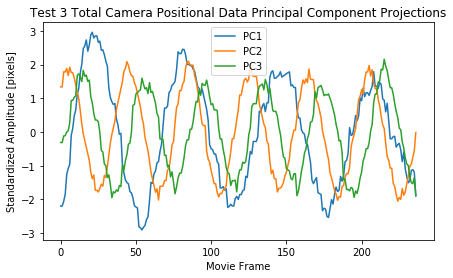

In [9]:
%matplotlib inline
camdf = pd.DataFrame(data=pc1)
camdfs = StandardScaler().fit_transform(camdf)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(camdfs)
pDf_1 = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

camdf = pd.DataFrame(data=pc2)
camdfs = StandardScaler().fit_transform(camdf)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(camdfs)
pDf_2 = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

camdf = pd.DataFrame(data=pc3)
camdfs = StandardScaler().fit_transform(camdf)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(camdfs)
pDf_3 = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

d = {'cam1x': pDf_1.loc[:, 'PC1'], 'cam1y': pDf_1.loc[:, 'PC2'], 'cam2x': pDf_2.loc[:, 'PC1'], 
     'cam2y': pDf_2.loc[:, 'PC2'], 'cam3x': pDf_3.loc[:, 'PC1'], 'cam3y': pDf_3.loc[:, 'PC2']}

df = pd.DataFrame(data=d)
df = df.iloc[0:237]
dfs = StandardScaler().fit_transform(df)


pca = PCA(n_components=6)
principalComponents = pca.fit_transform(dfs)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6'])

#Principle component oscillations
f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot(np.arange(0,237), principalDf.loc[:,'PC1'], label='PC1')
ax1.plot(np.arange(0,237), principalDf.loc[:,'PC2'], label='PC2')
ax1.plot(np.arange(0,237), principalDf.loc[:,'PC3'], label='PC3')
ax1.set_title('Test 3 Total Camera Positional Data Principal Component Projections')
ax1.set_ylabel('Standardized Amplitude [pixels]')
ax1.set_xlabel('Movie Frame')
ax1.legend()

In [ ]:
#Principle component oscillations
%matplotlib inline
f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot(np.arange(1,len(pca.explained_variance_) + 1,1).astype(int), 100*pca.explained_variance_/sum(pca.explained_variance_), 'bo', fillStyle='none')
ax1.set_xticks(np.arange(0,len(pca.explained_variance_) + 1,1)) 
ax1.set_title('Test 3 Explained Variance by Principal Component')
ax1.set_ylabel('Percent Explained Variance [%]')
ax1.set_xlabel('Principal Component')
ax1.set_xlim([0.5, 6.5])

In [12]:
#Test 4
#Data matrix contains camera pixel data RGB for spring mass movies
c_ = loadmat('cam1_4.mat')#load MATLAB .mat file into python as a dictionary
c1 = c_['vidFrames1_4']#raw camera data matrix

#Data matrix contains camera pixel data RGB for spring mass movies
c_ = loadmat('cam2_4.mat')#load MATLAB .mat file into python as a dictionary
c2 = c_['vidFrames2_4']#raw camera data matrix

#Data matrix contains camera pixel data RGB for spring mass movies
c_ = loadmat('cam3_4.mat')#load MATLAB .mat file into python as a dictionary
c3 = c_['vidFrames3_4']#raw camera data matrix

[w, h, rgb, tp] = c1.shape

In [13]:
pc1, nm1 = bucketTracker(c1, 0.6, True, 10, 100, 0.70, 0.0025, 0.3, 0.15, True)
pc2, nm2 = bucketTracker(c2, 0.9, True, 10, 100, 0.70, 0.00075, 0.3, 0.15, True)
pc3, nm3 = bucketTracker(c3, 0.6, True, 10, 100, 0.70, 0.0025, 0.25, 0.2, True)

In [ ]:
#show movie of fourth test, with filtered movie frames
%matplotlib notebook
f = plt.figure()
ax = f.gca()
ax.set_xlim(( 0, h))
ax.set_ylim((w, 0))

image = plt.imshow(nm3[:,:,0], animated=True)
graph, = plt.plot([], [], 'bo')

x = pc3[:, 0]
y = pc3[:, 1]

def animate(i):
    image.set_data(nm3[:,:,i])
    graph.set_data(x[i], y[i])
    ax.set_title(i)
    return image, graph,

ani = matplotlib.animation.FuncAnimation(f, animate, frames=tp, interval=200)
plt.show()

In [ ]:
#show movie of second test with actual video
%matplotlib notebook
f = plt.figure()
ax = f.gca()
ax.set_xlim(( 0, h))
ax.set_ylim((w, 0))

image = plt.imshow(c3[:,:,:,0], animated=True)
graph, = plt.plot([], [], 'bo')

x = pc3[:, 0]
y = pc3[:, 1]

def animate(i):
    image.set_data(c3[:,:,:,i])
    graph.set_data(x[i], y[i])
    ax.set_title(i)
    return image, graph,

ani = matplotlib.animation.FuncAnimation(f, animate, frames=tp, interval=200)
plt.show()

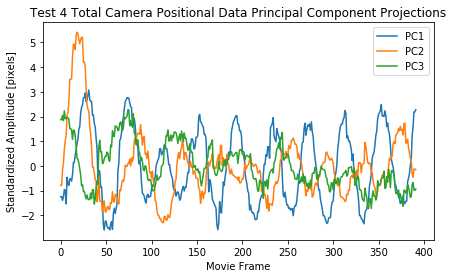

In [14]:
%matplotlib inline
camdf = pd.DataFrame(data=pc1)
camdfs = StandardScaler().fit_transform(camdf)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(camdfs)
pDf_1 = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

camdf = pd.DataFrame(data=pc2)
camdfs = StandardScaler().fit_transform(camdf)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(camdfs)
pDf_2 = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

camdf = pd.DataFrame(data=pc3)
camdfs = StandardScaler().fit_transform(camdf)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(camdfs)
pDf_3 = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

d = {'cam1x': pDf_1.loc[:, 'PC1'], 'cam1y': pDf_1.loc[:, 'PC2'], 'cam2x': pDf_2.loc[:, 'PC1'], 
     'cam2y': pDf_2.loc[:, 'PC2'], 'cam3x': pDf_3.loc[:, 'PC1'], 'cam3y': pDf_3.loc[:, 'PC2']}

df = pd.DataFrame(data=d)
df = df.iloc[0:392]
dfs = StandardScaler().fit_transform(df)


pca = PCA(n_components=6)
principalComponents = pca.fit_transform(dfs)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6'])

#Principle component oscillations
f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot(np.arange(0,392), principalDf.loc[:,'PC1'], label='PC1')
ax1.plot(np.arange(0,392), principalDf.loc[:,'PC2'], label='PC2')
ax1.plot(np.arange(0,392), principalDf.loc[:,'PC3'], label='PC3')
ax1.set_title('Test 4 Total Camera Positional Data Principal Component Projections')
ax1.set_ylabel('Standardized Amplitude [pixels]')
ax1.set_xlabel('Movie Frame')
ax1.legend()

In [ ]:
#Principle component oscillations
%matplotlib inline
f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot(np.arange(1,len(pca.explained_variance_) + 1,1).astype(int), 100*pca.explained_variance_/sum(pca.explained_variance_), 'bo', fillStyle='none')
ax1.set_xticks(np.arange(0,len(pca.explained_variance_) + 1,1)) 
ax1.set_title('Test 4 Explained Variance by Principal Component')
ax1.set_ylabel('Percent Explained Variance [%]')
ax1.set_xlabel('Principal Component')
ax1.set_xlim([0.5, 6.5])